A user has suggested a new measure of topical preparations containing antimicrobial ([GitHub issue](https://github.com/ebmdatalab/openprescribing/issues/2481)). The [BNF states](https://bnf.nice.org.uk/drug/emollient-creams-and-ointments-antimicrobial-containing.html) that topical _Preparations containing an antibacterial should be avoided unless infection is present or is a frequent complication._

In this notebook we set out to examine use of topical antibacterials.

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
sql = '''
SELECT
    pct,
    CAST(month AS DATE) AS month,
    bnf_name,
    bnf_code,
    SUM(items) AS items,
    SUM(actual_cost) AS cost
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct=ccg.code
WHERE
    ccg.org_type='CCG' AND
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM ebmdatalab.measures.dmd_objs_with_form_route
        WHERE 
        (form_route LIKE '%cream%' OR
        form_route LIKE'%oint%') 
        AND
        (bnf_code LIKE '131001%' OR # Antibacterial Preps Only Used Topically
        bnf_code LIKE '131002%' OR  #Antifungal Preparations 
        bnf_code LIKE 'Oilatum Plus%' OR #contains benzalkonium
        bnf_code LIKE 'Dermol%' OR #contains benzalkonium
        bnf_code LIKE 'Emulsiderm%') #contains benzalkonium
        )
GROUP BY pct, month, bnf_name, bnf_code
ORDER BY pct, month
'''

df_top_abx = bq.cached_read(sql, csv_path='df_top_abx.csv')
df_top_abx['month'] = df_top_abx['month'].astype('datetime64[ns]')
df_top_abx.head()

,pct,month,bnf_name,bnf_code,items,cost
0,00C,2010-08-01,Bactroban_Crm 2%,1310011M0BBABAB,2,12.12
1,00C,2010-08-01,Mupirocin_Crm 2%,1310011M0AAABAB,5,20.28
2,00C,2010-08-01,Canesten_Antifungal Crm 1%,1310020H0BBAHAB,1,2.00
3,00C,2010-08-01,Flamazine_Crm 1%,1310011Y0BBAAAA,3,15.78
4,00C,2010-08-01,Fucidin_Crm 2%,1310012F0BBAAAB,9,19.24


(0, 294323.6)

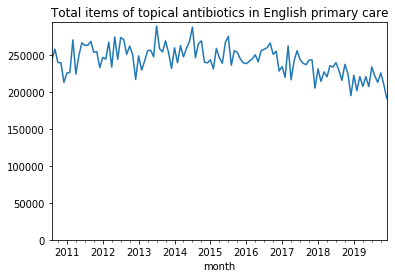

In [3]:

df_top_abx.groupby("month")['items'].sum().plot(kind='line', title="Total items of topical antibiotics in English primary care")
plt.ylim(0, )

In [4]:
df_top_abx.nunique()

pct            191
month          113
bnf_name        81
bnf_code        73
items         1677
cost        192958
dtype: int64

df_top_abx["bnf_name"].unique()

In [6]:

##groupby bnf name + code  to see largest volume in terms of items
df_products = df_top_abx.groupby(['bnf_code', 'bnf_name']).sum().reset_index().sort_values(by = 'items', ascending = False)
df_products.head(11)

,bnf_code,bnf_name,items,cost
17,1310012F0AAABAB,Fusidic Acid_Crm 2%,8022112,1.885158e+07
42,1310020H0AAABAB,Clotrimazole_Crm 1%,7735654,1.406565e+07
55,1310020N0AAAAAA,Miconazole Nit_Crm 2%,3344394,6.864498e+06
29,131002030AAAAAA,Terbinafine HCl_Crm 1%,2090164,7.108716e+06
18,1310012F0BBAAAB,Fucidin_Crm 2%,1013410,2.548536e+06
21,1310012K0AAAXAX,Metronidazole_Crm 0.75%,726001,5.080812e+06
43,1310020H0BBAAAB,Canesten_Crm 1%,677917,1.819881e+06
51,1310020L0AAAAAA,Ketoconazole_Crm 2%,588985,2.765571e+06
4,1310011M0AAABAB,Mupirocin_Crm 2%,407565,2.068342e+06
3,1310011M0AAAAAA,Mupirocin_Oint 2%,396979,2.193647e+06


In [7]:
ccg_total_abx = df_top_abx.groupby(["month", "pct"])["items"].sum().reset_index()
ccg_total_abx.head(5)

,month,pct,items
0,2010-08-01,00C,406
1,2010-08-01,00D,1393
2,2010-08-01,00J,1087
3,2010-08-01,00K,1414
4,2010-08-01,00L,1535


In [8]:
df_list = pd.read_csv('listsize.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(5)

,month,pct,list_size
0,2015-01-01,NaN,0
1,2015-01-01,00C,106673
2,2015-01-01,00D,288824
3,2015-01-01,00F,207011
4,2015-01-01,00G,163290


In [9]:
top_abx_1000 = pd.merge(ccg_total_abx, df_list, on=['month', 'pct'])
top_abx_1000['top_abx_items_per_1000'] = 1000* (top_abx_1000['items']/top_abx_1000['list_size'])
top_abx_1000.head(5)

,month,pct,items,list_size,top_abx_items_per_1000
0,2015-01-01,00C,419,106673,3.927892
1,2015-01-01,00D,1302,288824,4.507936
2,2015-01-01,00J,1050,252951,4.151002
3,2015-01-01,00K,1469,293006,5.013549
4,2015-01-01,00L,1564,322094,4.855725


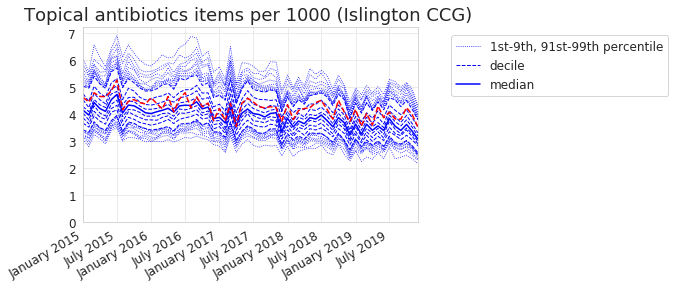

In [10]:
#create sample deciles & prototype measure
charts.deciles_chart(
        top_abx_1000,
        period_column='month',
        column='top_abx_items_per_1000',
        title="Topical antibiotics items per 1000 (Islington CCG) ",
        show_outer_percentiles=True)

#add in example CCG (Islington)
df_subject = top_abx_1000.loc[top_abx_1000['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['top_abx_items_per_1000'], 'r--')

plt.show()

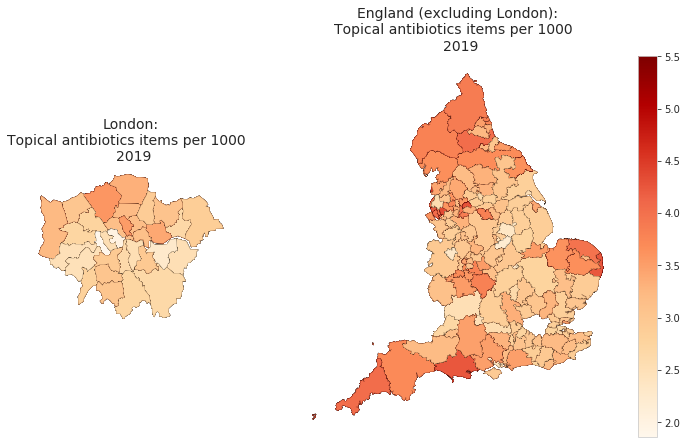

In [11]:
#create choropeth map of items per 1000 patients
plt.figure(figsize=(12, 7))
latest_top_abx_1000 = top_abx_1000.loc[(top_abx_1000['month'] >= '2019-01-01') & (top_abx_1000['month'] <= '2019-12-01')]
plt = maps.ccg_map(latest_top_abx_1000, title="Topical antibiotics items per 1000  \n  2019 ", column='top_abx_items_per_1000', separate_london=True)
plt.show()